In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

training_set = sio.loadmat('Training_set.mat')
train_x = training_set['train_x']
train_y= training_set['train_y']

test_set = sio.loadmat('Test_set.mat')
test_x = test_set['test_x']
test_y = test_set['test_y']

In [2]:
class_1 = (train_y==1).reshape(len(train_y))
class_2 = (train_y==2).reshape(len(train_y))
class_3 = (train_y==3).reshape(len(train_y))

In [4]:
N = len(train_x)

N1 = np.count_nonzero(class_1)
N2 = np.count_nonzero(class_2)
N3 = np.count_nonzero(class_3)
P1 = N1/N
P2 = N2/N
P3 = N3/N
name1 = ["$P_{\omega_1}$","$P_{\omega_2}$","$P_{\omega_3}$"]
pd.DataFrame([P1,P2,P3],name1,[""])

,
$P_{\omega_1}$,0.50
$P_{\omega_2}$,0.25
$P_{\omega_3}$,0.25


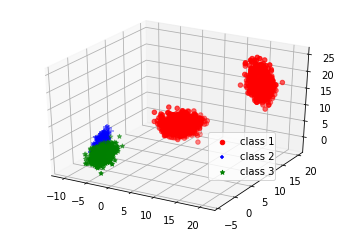

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
np.shape(train_y)
ax.scatter(train_x[class_1,1],train_x[class_1,2],train_x[class_1,3],c='r', marker='o',label='class 1')
ax.scatter(train_x[class_2,1],train_x[class_2,2],train_x[class_2,3],c='b', marker='+',label='class 2')
ax.scatter(train_x[class_3,1],train_x[class_3,2],train_x[class_3,3],c='g', marker='*',label='class 3')
plt.legend(bbox_to_anchor=(0.6, .2, .2, .2), loc=3,ncol=1, mode="expand", borderaxespad=0.)
plt.show()

i) Parametric approach

In [20]:
from sklearn import mixture
class1 = mixture.GaussianMixture(n_components=2, covariance_type='full')
class1.fit(train_x[class_1,:])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [21]:
class1_scores = np.exp(class1.score_samples(test_x))*P1

In [22]:
from numpy import matlib
m2 = np.mean(train_x[class_2,:],0)
m3 = np.mean(train_x[class_3,:],0)
S2 = 1/N2*((train_x[class_2,:] - np.matlib.repmat(m2,N2,1)).T).dot((train_x[class_2,:] - np.matlib.repmat(m2,N2,1)))
S3 = 1/N3*((train_x[class_3,:] - np.matlib.repmat(m3,N3,1)).T).dot((train_x[class_3,:] - np.matlib.repmat(m3,N3,1)))
class2 = multivariate_normal(m2,S2)
class2_scores = class2.pdf(test_x)*P2
class3 = multivariate_normal(m3,S3)
class3_scores = class3.pdf(test_x)*P3
scores = np.array([class1_scores,class2_scores,class3_scores]).T

In [23]:
Btest_y = np.argmax(scores,axis=1).reshape(len(scores),1) + 1
Error = 1 - (np.sum(i==1 for i in Btest_y == test_y))/len(Btest_y)
print("Classification error rate - Parametric approach", Error)

Classification error rate - Parametric approach [0.012]


c:\users\thomas\envs\notebook\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


ii) Non-parametric approach

In [19]:
from scipy.spatial import distance
from math import pi

#estimate pairwise distances betweeen test and training samples
dist = distance.cdist(test_x,train_x,'euclidean')

#estimate the volume of a 4d-hypersphere
#- dist corresponds to its radius
def vol(dist):
    return 0.5*(pi**2)*(dist**4)

k=5 #number of nearest neighbors
class1_scores = k/(N1*vol(np.sort(dist[:,class_1])[:,4]))*P1
class2_scores = k/(N2*vol(np.sort(dist[:,class_2])[:,4]))*P2
class3_scores = k/(N3*vol(np.sort(dist[:,class_3])[:,4]))*P3

scores = np.array([class1_scores,class2_scores,class3_scores]).T

Btest_y = np.argmax(scores,axis=1).reshape(len(scores),1) + 1

Error = 1 - (np.sum(i==1 for i in Btest_y == test_y))/len(Btest_y)
print("Classification error rate - Non-parametric (kNN density) approach", Error)

Classification error rate - Non-parametric (kNN density) approach [0.0165]


c:\users\thomas\envs\notebook\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


b) Confusion matrix

* parametric approach

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, Btest_y)

array([[2000,    0,    0],
       [   0,  986,   14],
       [   0,   34,  966]], dtype=int64)

* non-parametric approach

In [14]:
confusion_matrix(test_y, Btest_y)

array([[2000,    0,    0],
       [   0,  991,    9],
       [   0,   57,  943]], dtype=int64)